In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from scipy.signal import filtfilt, butter, argrelextrema
import numpy as np
%matplotlib inline 

In [17]:
# Файл с данными
csv_name = "Gleb ice 19 03 20_ensor_2020-03-19T11.16.30.288_FC7005861603_"
date = 190320
# Устанавливаем время старта пдля синхронизации с камерой
strt_dt = 6478

# Устанавливаем время клика синхронизации камеры
click_t = 7700

## Измерения Акселерометра

          x      y      z       sum
s                                  
7706 -0.045  0.006  1.026  1.027004
7709 -0.045  0.006  1.026  1.027004
7714 -0.046  0.007  1.024  1.025057
7720 -0.050  0.009  1.026  1.027257
7725 -0.051  0.010  1.024  1.025318


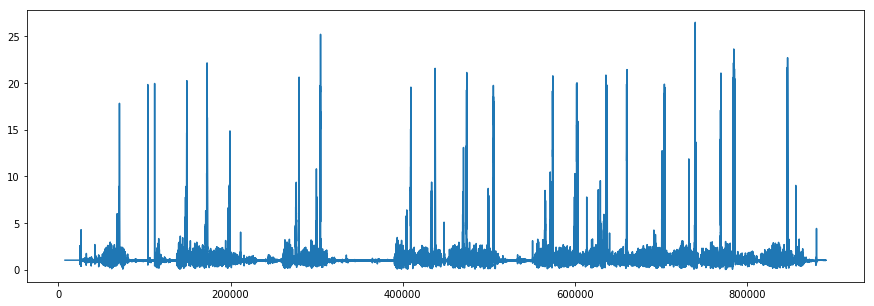

In [18]:
data_a = pd.read_csv(f"{csv_name}Accelerometer.csv")
data_a.columns = ['ms','t','s','x','y','z']
data_a = data_a.drop(['ms','t'], axis=1)

data_a['s']= (data_a['s']*1000-strt_dt).apply(int)
data_a = data_a.groupby('s').min()

data_a = data_a.loc[click_t:]
data_a['sum'] = (data_a['x']**2 + data_a['y']**2 + data_a['z']**2)**0.5

print(data_a.head(5))
plt.figure(figsize=(15,5))
plt.plot(data_a['sum'])

          x      y      z       sum
s                                  
7701  0.854 -0.183  0.366  0.946975
7705  0.610 -0.366  0.488  0.862670
7711  0.366 -0.488  0.488  0.781181
7715  0.244 -0.244  0.366  0.503019
7721 -0.122 -0.244  0.610  0.668222


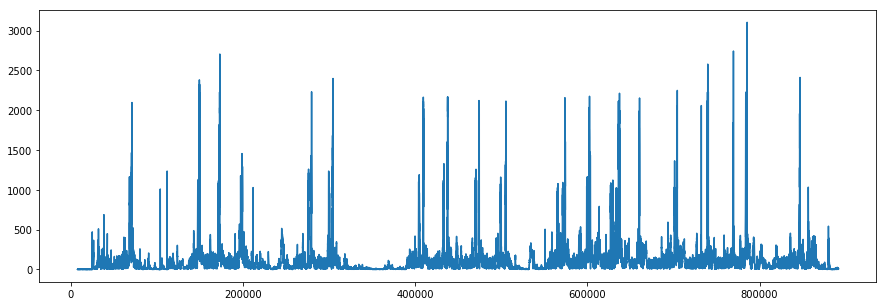

In [19]:
data_g = pd.read_csv(f"{csv_name}Gyroscope.csv")
data_g.columns = ['ms','t','s','x','y','z']
data_g = data_g.drop(['ms','t'], axis=1)

# Устанавливаем время старта пдля синхронизации с камерой
data_g['s']= (data_g['s']*1000-strt_dt).apply(int)
data_g = data_g.groupby('s').min()

# Устанавливаем время клика синхронизации камеры
data_g = data_g.loc[click_t:]
data_g['sum'] = (data_g['x']**2 + data_g['y']**2 + data_g['z']**2)**0.5

print(data_g.head(5))
plt.figure(figsize=(15,5))
plt.plot(data_g['sum'])

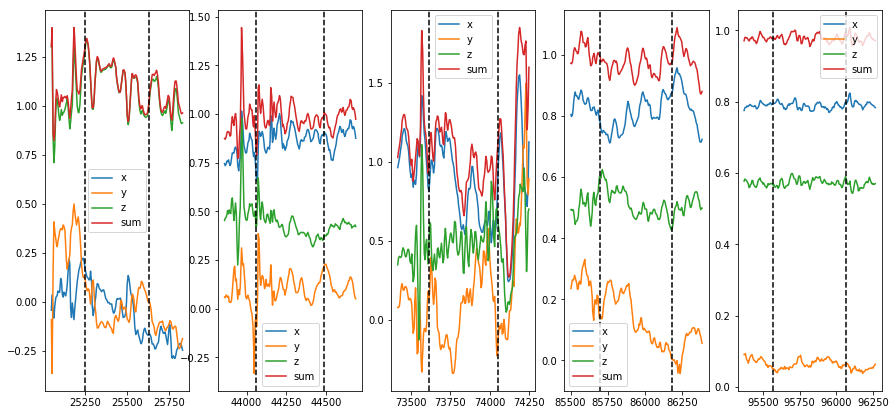

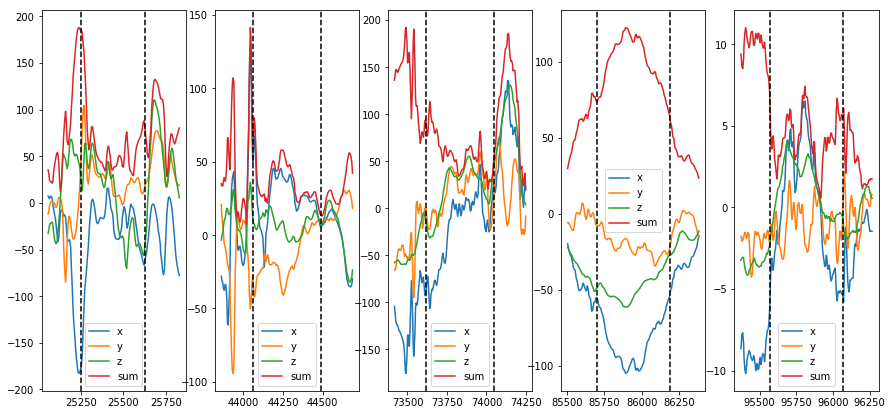

In [68]:
# Отсечки по прыжкам зафиксированные по камере
jmps_real = [(25250,25630),(44060,44490),(73615,74050),(85700,86187),
             (95568,96068),(146170,146470),(158160,158580),(182500,182940),
             (205100,205540),(234650,235110)]


# Количество прыжков для отображения (меньше размера jmps_real) 
num = 5
axis = ['x','y','z','sum']

def subploti(data):
    plt.figure(figsize=(15,7))
    for j, i in enumerate(jmps_real[:num]):
        a,b = i
        plt.subplot(1,num,j+1)
        plt.plot(data[axis].loc[a-200:b+200])
        plt.axvline(a ,color='black', ls='--')
        plt.axvline(b ,color='black', ls='--')
        plt.legend(axis)

subploti(data_a)
subploti(data_g)

In [524]:
def get_csc(a, max_gap=150, min_acc=4.5, min_csc_size=300):
    ind = a[a['a']>min_acc].index.values

    # объединение всплесков с каскадами
    res = [[ind[0]]]
    for i in range(len(ind)-1):
        d = ind[i+1]-ind[i]
        if d>max_gap:
            res[-1].append(ind[i])
            res.append([ind[i+1]])
    res[-1].append(ind[-1])
    # удаление каскадов в которые не поместился бы нормальный прыжок
    result = []
    for c in res:
        a,b = c
        if b-a>min_csc_size:
            # Корректировка, чтобы захватить минимумы после каскада
            result.append((a-140, b))
    return result

In [587]:
def get_jmp(a,f=0.015):
    if max(a)>10:
        t = a.index.values
        ti = list(range(t[0],t[-1],1))
        a = pd.merge(pd.DataFrame(index=ti), a,left_index=True, right_index=True, how='outer')
        a = a.interpolate()
        
        a_n = fminmax(a, 0.5, 'hp')
        g = np.gradient(a_n.T[0],edge_order=2)

        dat = fminmax(g, f, 'lp')
        g = pd.Series(dat, index=a.index.values)

        plt.plot(g*10)

        ex = list(argrelextrema(dat, np.greater, order = 10)[0])
        
        if len(ex) >=2:
            g = g.iloc[ex]
            ex = g.nlargest(2).index
            plt.plot(a.loc[ex], '--', marker='x')
            ex = list(ex)

            t0,tn = min(ex),max(ex)
            if tn-t0 > 250:
                return [(t0,tn, a.loc[t0-50:tn+50])]
            else:
                return None
        else:
            return None
    else:
        return None

692
735
736
679


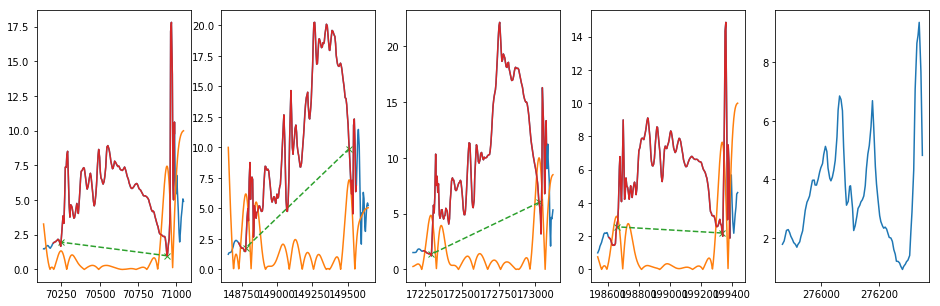

In [588]:
csc = get_csc(data, min_acc=4.5)
plt.figure(figsize=(16,5))
j=1
csc= csc[:5]
for i in range(len(csc)):
    plt.subplot(1,len(csc),j)
    a,b = csc[i]
    plt.plot(data['a'].loc[a:b])
    x = get_jmp(data['a'].loc[a:b],0.015)
    if x:
        a,b,pl = x
        print(b-a)
        plt.plot(pl)
    j+=1


488


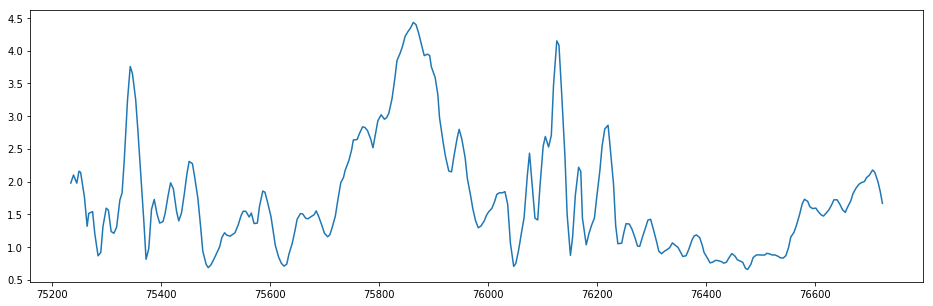

In [490]:
csc = get_csc(data, min_acc=2)
plt.figure(figsize=(16,5))
j=1
a,b = csc[3]
x = get_jmp(data['a'].loc[a:b],0.03)
print(b-a)
plt.plot(data['a'].loc[a-500:b+500])

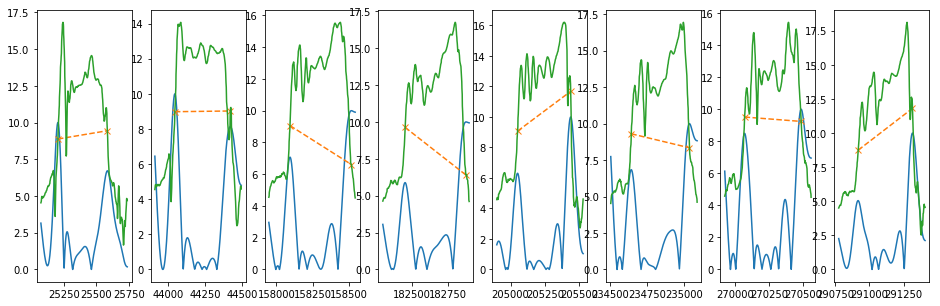

In [532]:
csc = get_csc(data)
plt.figure(figsize=(16,5))
j=1
for i in range(len(csc)):
    plt.subplot(1,len(csc),j)
    a,b = csc[i]
    x = get_jmp(data['a'].loc[a:b])
    plt.plot(data['a'].loc[a:b])
    j+=1


In [545]:
a, b = 70000, 200000
da = data.loc[a:b][['x','y','z']]
da

,x,y,z
s,,,
70004,0.139,0.051,0.723
70008,0.152,0.110,0.817
70014,0.192,0.148,0.844
70019,0.224,0.226,0.819
70023,0.239,0.273,0.798
70029,0.234,0.281,0.796
70033,0.223,0.320,0.814
70038,0.249,0.215,0.832
70043,0.242,0.061,0.841


In [562]:
# Достаем данные из БД
from mysql import connector 
sid = 5
conn = connector.connect(host='127.0.0.1', user='root', password='T0_Gather', database='NAVKA2')
cursor = conn.cursor()
for i in da.iterrows():
    a = f"({sid}, {i[0]}, {i[1][0]}, {i[1][1]}, {i[1][2]})"
    #cursor.execute(f"INSERT INTO vAcc (sid,tick,x,y,z) VALUES {a}")
conn.commit()

(5, 70004, 0.139, 0.051, 0.723)
(5, 70008, 0.152, 0.11, 0.8170000000000001)
(5, 70014, 0.192, 0.14800000000000002, 0.8440000000000001)
(5, 70019, 0.22399999999999998, 0.226, 0.8190000000000001)
(5, 70023, 0.239, 0.273, 0.7979999999999999)
(5, 70029, 0.23399999999999999, 0.281, 0.7959999999999999)
(5, 70033, 0.223, 0.32, 0.8140000000000001)
(5, 70038, 0.249, 0.215, 0.8320000000000001)
(5, 70043, 0.242, 0.061, 0.841)
(5, 70048, 0.17300000000000001, 0.006, 0.861)
(5, 70054, 0.134, -0.047, 0.8440000000000001)
(5, 70058, 0.155, -0.223, 0.7879999999999999)
(5, 70063, 0.133, -0.20800000000000002, 0.792)
(5, 70068, 0.139, -0.037000000000000005, 0.855)
(5, 70073, 0.168, 0.087, 0.976)
(5, 70077, 0.19699999999999998, 0.183, 1.119)
(5, 70083, 0.245, 0.225, 1.18)
(5, 70087, 0.33299999999999996, 0.22, 1.2590000000000001)
(5, 70093, 0.46, 0.264, 1.3940000000000001)
(5, 70098, 0.589, 0.303, 1.5219999999999998)
(5, 70102, 0.644, 0.324, 1.571)
(5, 70108, 0.621, 0.363, 1.537)
(5, 70112, 0.52, 0.395, 1.47

(5, 73134, 0.466, 0.182, 0.665)
(5, 73140, 0.47100000000000003, 0.149, 0.6920000000000001)
(5, 73145, 0.48700000000000004, 0.10800000000000001, 0.721)
(5, 73149, 0.494, 0.081, 0.7040000000000001)
(5, 73155, 0.5, 0.075, 0.6940000000000001)
(5, 73159, 0.536, 0.094, 0.7)
(5, 73165, 0.589, 0.153, 0.7140000000000001)
(5, 73168, 0.639, 0.23600000000000002, 0.71)
(5, 73174, 0.6629999999999999, 0.28300000000000003, 0.6990000000000001)
(5, 73180, 0.65, 0.265, 0.71)
(5, 73183, 0.63, 0.273, 0.7340000000000001)
(5, 73189, 0.637, 0.341, 0.7290000000000001)
(5, 73194, 0.652, 0.40700000000000003, 0.679)
(5, 73198, 0.6629999999999999, 0.444, 0.625)
(5, 73205, 0.6729999999999999, 0.489, 0.588)
(5, 73209, 0.6890000000000001, 0.53, 0.583)
(5, 73213, 0.682, 0.523, 0.5920000000000001)
(5, 73219, 0.65, 0.485, 0.609)
(5, 73224, 0.627, 0.473, 0.611)
(5, 73230, 0.612, 0.495, 0.591)
(5, 73234, 0.606, 0.49200000000000005, 0.564)
(5, 73238, 0.5870000000000001, 0.461, 0.5429999999999999)
(5, 73244, 0.5589999999999

(5, 76716, 1.005, 0.321, 0.267)
(5, 76720, 1.063, 0.41, 0.218)
(5, 76726, 1.075, 0.44799999999999995, 0.292)
(5, 76730, 1.156, 0.442, 0.307)
(5, 76736, 1.168, 0.371, 0.21600000000000003)
(5, 76741, 1.018, 0.14, 0.247)
(5, 76745, 0.8640000000000001, -0.040999999999999995, 0.355)
(5, 76751, 0.772, 0.057999999999999996, 0.353)
(5, 76754, 0.782, 0.37799999999999995, 0.25)
(5, 76760, 0.853, 0.564, 0.21899999999999997)
(5, 76766, 0.934, 0.5579999999999999, 0.299)
(5, 76769, 0.9390000000000001, 0.47, 0.521)
(5, 76775, 0.8859999999999999, 0.299, 0.713)
(5, 76780, 0.88, 0.26899999999999996, 0.706)
(5, 76784, 0.772, 0.20800000000000002, 0.66)
(5, 76790, 0.654, 0.115, 0.6990000000000001)
(5, 76795, 0.612, 0.10300000000000001, 0.7979999999999999)
(5, 76799, 0.654, 0.18600000000000003, 0.902)
(5, 76804, 0.772, 0.214, 1.006)
(5, 76810, 0.857, -0.004, 1.167)
(5, 76814, 0.865, -0.245, 1.3030000000000002)
(5, 76819, 0.853, -0.281, 1.354)
(5, 76824, 0.852, -0.249, 1.324)
(5, 76830, 0.835, -0.134, 1.2209

(5, 80243, 0.987, 0.183, 0.386)
(5, 80248, 0.898, 0.015, 0.37799999999999995)
(5, 80253, 0.878, 0.033, 0.32)
(5, 80258, 0.965, 0.21899999999999997, 0.28300000000000003)
(5, 80262, 0.9059999999999999, 0.185, 0.264)
(5, 80268, 0.722, -0.012, 0.184)
(5, 80272, 0.69, 0.091, 0.077)
(5, 80278, 0.8, 0.366, 0.032)
(5, 80283, 0.84, 0.506, 0.07200000000000001)
(5, 80287, 0.8320000000000001, 0.43200000000000005, 0.136)
(5, 80293, 0.848, 0.311, 0.192)
(5, 80297, 0.885, 0.402, 0.21600000000000003)
(5, 80302, 0.9229999999999999, 0.53, 0.226)
(5, 80308, 0.922, 0.48100000000000004, 0.226)
(5, 80312, 0.892, 0.33, 0.204)
(5, 80318, 0.895, 0.287, 0.20800000000000002)
(5, 80322, 0.9179999999999999, 0.32299999999999995, 0.242)
(5, 80327, 0.9009999999999999, 0.315, 0.267)
(5, 80333, 0.872, 0.26899999999999996, 0.262)
(5, 80337, 0.87, 0.289, 0.264)
(5, 80343, 0.875, 0.35700000000000004, 0.27699999999999997)
(5, 80347, 0.8759999999999999, 0.41200000000000003, 0.303)
(5, 80352, 0.8959999999999999, 0.4220000000

(5, 83577, 0.792, 0.205, 0.563)
(5, 83583, 0.7879999999999999, 0.207, 0.57)
(5, 83587, 0.7809999999999999, 0.207, 0.564)
(5, 83592, 0.7879999999999999, 0.19899999999999998, 0.555)
(5, 83598, 0.795, 0.203, 0.54)
(5, 83602, 0.792, 0.204, 0.5329999999999999)
(5, 83606, 0.795, 0.203, 0.539)
(5, 83612, 0.7979999999999999, 0.209, 0.5429999999999999)
(5, 83617, 0.797, 0.20800000000000002, 0.541)
(5, 83623, 0.8, 0.20800000000000002, 0.542)
(5, 83627, 0.7979999999999999, 0.21, 0.544)
(5, 83631, 0.795, 0.21600000000000003, 0.5489999999999999)
(5, 83637, 0.797, 0.215, 0.5539999999999999)
(5, 83642, 0.797, 0.212, 0.561)
(5, 83646, 0.7979999999999999, 0.21100000000000002, 0.557)
(5, 83652, 0.8, 0.20199999999999999, 0.557)
(5, 83656, 0.804, 0.19699999999999998, 0.552)
(5, 83662, 0.8059999999999999, 0.198, 0.5489999999999999)
(5, 83667, 0.8, 0.193, 0.534)
(5, 83671, 0.7909999999999999, 0.2, 0.523)
(5, 83677, 0.7859999999999999, 0.207, 0.52)
(5, 83680, 0.79, 0.201, 0.531)
(5, 83686, 0.785, 0.198, 0.54

(5, 87346, 0.845, 0.064, 0.45399999999999996)
(5, 87352, 0.861, 0.065, 0.46)
(5, 87356, 0.875, 0.062, 0.461)
(5, 87362, 0.8759999999999999, 0.061, 0.461)
(5, 87367, 0.875, 0.063, 0.447)
(5, 87370, 0.875, 0.063, 0.435)
(5, 87377, 0.8759999999999999, 0.06, 0.43799999999999994)
(5, 87381, 0.879, 0.055, 0.44299999999999995)
(5, 87385, 0.887, 0.054000000000000006, 0.447)
(5, 87392, 0.887, 0.055999999999999994, 0.449)
(5, 87396, 0.879, 0.055, 0.451)
(5, 87402, 0.8759999999999999, 0.06, 0.45799999999999996)
(5, 87406, 0.866, 0.065, 0.455)
(5, 87411, 0.8540000000000001, 0.066, 0.45299999999999996)
(5, 87417, 0.848, 0.061, 0.456)
(5, 87421, 0.8390000000000001, 0.057, 0.45899999999999996)
(5, 87424, 0.841, 0.06, 0.45899999999999996)
(5, 87430, 0.8370000000000001, 0.065, 0.45899999999999996)
(5, 87436, 0.836, 0.07, 0.46)
(5, 87441, 0.833, 0.07200000000000001, 0.46)
(5, 87445, 0.831, 0.076, 0.46399999999999997)
(5, 87450, 0.826, 0.083, 0.461)
(5, 87456, 0.83, 0.086, 0.462)
(5, 87459, 0.838, 0.087,

(5, 90730, 0.812, 0.134, 0.5660000000000001)
(5, 90736, 0.795, 0.142, 0.57)
(5, 90739, 0.765, 0.152, 0.568)
(5, 90745, 0.7340000000000001, 0.16, 0.563)
(5, 90751, 0.7, 0.175, 0.555)
(5, 90754, 0.672, 0.191, 0.5479999999999999)
(5, 90760, 0.648, 0.203, 0.54)
(5, 90765, 0.6409999999999999, 0.221, 0.522)
(5, 90769, 0.639, 0.24600000000000002, 0.5)
(5, 90774, 0.644, 0.253, 0.494)
(5, 90780, 0.657, 0.245, 0.49)
(5, 90784, 0.688, 0.24, 0.48)
(5, 90789, 0.723, 0.221, 0.47)
(5, 90794, 0.754, 0.18, 0.469)
(5, 90799, 0.7879999999999999, 0.12300000000000001, 0.46399999999999997)
(5, 90804, 0.82, 0.057, 0.45899999999999996)
(5, 90809, 0.848, 0.012, 0.452)
(5, 90814, 0.865, -0.017, 0.446)
(5, 90819, 0.872, -0.049, 0.446)
(5, 90824, 0.888, -0.085, 0.449)
(5, 90830, 0.9059999999999999, -0.127, 0.45)
(5, 90834, 0.92, -0.151, 0.465)
(5, 90840, 0.934, -0.159, 0.486)
(5, 90844, 0.9490000000000001, -0.156, 0.507)
(5, 90849, 0.9620000000000001, -0.132, 0.526)
(5, 90855, 0.9740000000000001, -0.113, 0.539)
(

(5, 92418, 0.747, 0.175, 0.632)
(5, 92422, 0.735, 0.174, 0.63)
(5, 92428, 0.73, 0.175, 0.6409999999999999)
(5, 92432, 0.7290000000000001, 0.18, 0.6509999999999999)
(5, 92437, 0.732, 0.184, 0.652)
(5, 92442, 0.731, 0.182, 0.66)
(5, 92447, 0.733, 0.179, 0.659)
(5, 92451, 0.737, 0.17600000000000002, 0.6629999999999999)
(5, 92457, 0.737, 0.17600000000000002, 0.672)
(5, 92461, 0.738, 0.171, 0.6679999999999999)
(5, 92467, 0.738, 0.156, 0.657)
(5, 92472, 0.733, 0.151, 0.6459999999999999)
(5, 92476, 0.733, 0.162, 0.65)
(5, 92482, 0.7340000000000001, 0.162, 0.659)
(5, 92486, 0.7390000000000001, 0.154, 0.654)
(5, 92491, 0.7390000000000001, 0.141, 0.653)
(5, 92497, 0.745, 0.14, 0.647)
(5, 92501, 0.7509999999999999, 0.146, 0.647)
(5, 92507, 0.746, 0.14, 0.6509999999999999)
(5, 92510, 0.742, 0.127, 0.649)
(5, 92516, 0.743, 0.11900000000000001, 0.653)
(5, 92522, 0.745, 0.11199999999999999, 0.657)
(5, 92525, 0.747, 0.111, 0.652)
(5, 92530, 0.747, 0.105, 0.647)
(5, 92536, 0.7440000000000001, 0.1, 0.63

(5, 95494, 0.7959999999999999, 0.081, 0.574)
(5, 95498, 0.794, 0.078, 0.569)
(5, 95504, 0.792, 0.07400000000000001, 0.5720000000000001)
(5, 95508, 0.792, 0.073, 0.568)
(5, 95514, 0.789, 0.07, 0.563)
(5, 95519, 0.789, 0.063, 0.562)
(5, 95523, 0.7879999999999999, 0.06, 0.5579999999999999)
(5, 95529, 0.792, 0.062, 0.563)
(5, 95533, 0.7909999999999999, 0.055, 0.57)
(5, 95538, 0.7929999999999999, 0.059000000000000004, 0.5670000000000001)
(5, 95543, 0.7929999999999999, 0.059000000000000004, 0.569)
(5, 95548, 0.797, 0.06, 0.569)
(5, 95554, 0.795, 0.059000000000000004, 0.5710000000000001)
(5, 95558, 0.7909999999999999, 0.057, 0.57)
(5, 95563, 0.792, 0.052000000000000005, 0.57)
(5, 95568, 0.795, 0.051, 0.5660000000000001)
(5, 95573, 0.7959999999999999, 0.051, 0.568)
(5, 95577, 0.795, 0.046, 0.562)
(5, 95583, 0.7959999999999999, 0.048, 0.56)
(5, 95587, 0.7979999999999999, 0.043, 0.562)
(5, 95593, 0.8029999999999999, 0.040999999999999995, 0.565)
(5, 95598, 0.807, 0.04, 0.564)
(5, 95602, 0.8059999

(5, 99184, 0.732, 0.14, 0.59)
(5, 99188, 0.728, 0.145, 0.5870000000000001)
(5, 99194, 0.7240000000000001, 0.146, 0.589)
(5, 99198, 0.7290000000000001, 0.142, 0.602)
(5, 99204, 0.731, 0.141, 0.606)
(5, 99209, 0.738, 0.134, 0.614)
(5, 99213, 0.742, 0.13, 0.623)
(5, 99219, 0.75, 0.128, 0.635)
(5, 99223, 0.7559999999999999, 0.128, 0.631)
(5, 99228, 0.765, 0.126, 0.625)
(5, 99233, 0.772, 0.125, 0.614)
(5, 99238, 0.779, 0.124, 0.606)
(5, 99244, 0.7909999999999999, 0.125, 0.612)
(5, 99248, 0.8029999999999999, 0.11900000000000001, 0.62)
(5, 99252, 0.812, 0.113, 0.617)
(5, 99258, 0.8109999999999999, 0.10400000000000001, 0.609)
(5, 99263, 0.8109999999999999, 0.098, 0.597)
(5, 99267, 0.807, 0.09300000000000001, 0.575)
(5, 99273, 0.7959999999999999, 0.09, 0.562)
(5, 99277, 0.7909999999999999, 0.09300000000000001, 0.5529999999999999)
(5, 99283, 0.784, 0.095, 0.5479999999999999)
(5, 99288, 0.78, 0.084, 0.546)
(5, 99292, 0.777, 0.08, 0.542)
(5, 99298, 0.775, 0.084, 0.54)
(5, 99302, 0.774, 0.087, 0.53

(5, 102518, 0.804, 0.077, 0.532)
(5, 102522, 0.7959999999999999, 0.07200000000000001, 0.532)
(5, 102528, 0.799, 0.07, 0.5379999999999999)
(5, 102532, 0.804, 0.069, 0.542)
(5, 102538, 0.8029999999999999, 0.068, 0.5479999999999999)
(5, 102543, 0.812, 0.07400000000000001, 0.5489999999999999)
(5, 102547, 0.8220000000000001, 0.077, 0.544)
(5, 102553, 0.8320000000000001, 0.07, 0.545)
(5, 102557, 0.84, 0.077, 0.556)
(5, 102562, 0.8390000000000001, 0.084, 0.555)
(5, 102567, 0.826, 0.081, 0.54)
(5, 102572, 0.816, 0.078, 0.531)
(5, 102578, 0.81, 0.079, 0.5329999999999999)
(5, 102582, 0.815, 0.08800000000000001, 0.542)
(5, 102586, 0.8190000000000001, 0.086, 0.547)
(5, 102592, 0.8170000000000001, 0.077, 0.547)
(5, 102597, 0.812, 0.075, 0.5329999999999999)
(5, 102601, 0.809, 0.079, 0.53)
(5, 102607, 0.81, 0.078, 0.528)
(5, 102611, 0.81, 0.079, 0.519)
(5, 102617, 0.809, 0.076, 0.517)
(5, 102622, 0.8059999999999999, 0.077, 0.518)
(5, 102626, 0.807, 0.079, 0.521)
(5, 102632, 0.802, 0.07400000000000001

(5, 106275, 0.937, -0.01, 0.8079999999999999)
(5, 106282, 0.977, 0.042, 0.852)
(5, 106287, 0.986, 0.059000000000000004, 0.851)
(5, 106290, 0.9520000000000001, 0.059000000000000004, 0.828)
(5, 106297, 0.895, 0.064, 0.7859999999999999)
(5, 106301, 0.838, 0.1, 0.748)
(5, 106307, 0.813, 0.127, 0.732)
(5, 106312, 0.8140000000000001, 0.131, 0.733)
(5, 106316, 0.818, 0.146, 0.746)
(5, 106322, 0.8140000000000001, 0.16399999999999998, 0.7340000000000001)
(5, 106326, 0.797, 0.151, 0.696)
(5, 106331, 0.767, 0.14, 0.6559999999999999)
(5, 106336, 0.737, 0.158, 0.604)
(5, 106341, 0.72, 0.18100000000000002, 0.561)
(5, 106347, 0.71, 0.183, 0.542)
(5, 106351, 0.693, 0.161, 0.5379999999999999)
(5, 106355, 0.6629999999999999, 0.149, 0.5379999999999999)
(5, 106361, 0.629, 0.135, 0.547)
(5, 106366, 0.599, 0.111, 0.565)
(5, 106370, 0.598, 0.084, 0.5920000000000001)
(5, 106376, 0.597, 0.071, 0.628)
(5, 106379, 0.604, 0.062, 0.674)
(5, 106385, 0.625, 0.052000000000000005, 0.708)
(5, 106391, 0.6509999999999999

(5, 109685, 0.813, 0.105, 0.525)
(5, 109689, 0.82, 0.10099999999999999, 0.524)
(5, 109694, 0.8170000000000001, 0.10099999999999999, 0.52)
(5, 109700, 0.8220000000000001, 0.10099999999999999, 0.515)
(5, 109704, 0.818, 0.091, 0.501)
(5, 109709, 0.8190000000000001, 0.094, 0.507)
(5, 109714, 0.826, 0.10300000000000001, 0.517)
(5, 109719, 0.8270000000000001, 0.10400000000000001, 0.525)
(5, 109724, 0.83, 0.102, 0.539)
(5, 109729, 0.83, 0.1, 0.542)
(5, 109735, 0.833, 0.107, 0.541)
(5, 109739, 0.8370000000000001, 0.10800000000000001, 0.5429999999999999)
(5, 109744, 0.833, 0.107, 0.534)
(5, 109750, 0.8270000000000001, 0.10300000000000001, 0.521)
(5, 109754, 0.816, 0.096, 0.506)
(5, 109758, 0.8079999999999999, 0.09699999999999999, 0.502)
(5, 109764, 0.813, 0.091, 0.502)
(5, 109769, 0.813, 0.079, 0.51)
(5, 109774, 0.809, 0.08, 0.515)
(5, 109779, 0.81, 0.08800000000000001, 0.521)
(5, 109783, 0.81, 0.08800000000000001, 0.518)
(5, 109789, 0.81, 0.084, 0.51)
(5, 109793, 0.8140000000000001, 0.09300000

(5, 112653, 0.792, 0.07400000000000001, 0.46)
(5, 112657, 0.7929999999999999, 0.063, 0.45)
(5, 112663, 0.8, 0.047, 0.445)
(5, 112668, 0.8059999999999999, 0.053, 0.44799999999999995)
(5, 112672, 0.8079999999999999, 0.057, 0.445)
(5, 112678, 0.816, 0.049, 0.429)
(5, 112682, 0.8320000000000001, 0.055999999999999994, 0.40700000000000003)
(5, 112687, 0.836, 0.057999999999999996, 0.386)
(5, 112692, 0.845, 0.048, 0.396)
(5, 112697, 0.8640000000000001, 0.055999999999999994, 0.408)
(5, 112703, 0.885, 0.055, 0.41600000000000004)
(5, 112707, 0.91, 0.057, 0.41600000000000004)
(5, 112711, 0.9309999999999999, 0.068, 0.41100000000000003)
(5, 112717, 0.93, 0.073, 0.406)
(5, 112722, 0.917, 0.057999999999999996, 0.425)
(5, 112726, 0.9179999999999999, 0.033, 0.44299999999999995)
(5, 112732, 0.945, 0.042, 0.45399999999999996)
(5, 112736, 0.9620000000000001, 0.057, 0.449)
(5, 112742, 0.9490000000000001, 0.067, 0.439)
(5, 112747, 0.93, 0.065, 0.451)
(5, 112751, 0.93, 0.057, 0.479)
(5, 112757, 0.930999999999

(5, 116174, 0.6970000000000001, 0.223, 0.885)
(5, 116179, 0.65, 0.168, 0.841)
(5, 116185, 0.51, 0.20800000000000002, 0.9790000000000001)
(5, 116189, 0.5660000000000001, 0.16399999999999998, 0.99)
(5, 116194, 0.601, 0.156, 0.8809999999999999)
(5, 116199, 0.539, 0.311, 0.799)
(5, 116204, 0.601, 0.38799999999999996, 0.6859999999999999)
(5, 116209, 0.613, 0.221, 0.782)
(5, 116214, 0.527, 0.096, 1.093)
(5, 116218, 0.614, 0.258, 1.165)
(5, 116224, 0.8190000000000001, 0.483, 0.809)
(5, 116229, 0.782, 0.511, 0.48200000000000004)
(5, 116234, 0.5820000000000001, 0.35700000000000004, 0.579)
(5, 116239, 0.516, 0.204, 0.8859999999999999)
(5, 116243, 0.639, 0.26, 0.998)
(5, 116249, 0.731, 0.385, 0.862)
(5, 116253, 0.685, 0.418, 0.695)
(5, 116258, 0.5720000000000001, 0.384, 0.654)
(5, 116264, 0.502, 0.341, 0.708)
(5, 116268, 0.498, 0.29600000000000004, 0.8)
(5, 116274, 0.524, 0.287, 0.853)
(5, 116278, 0.562, 0.35700000000000004, 0.809)
(5, 116283, 0.5660000000000001, 0.405, 0.732)
(5, 116289, 0.516, 

(5, 119217, 0.682, 0.369, 0.442)
(5, 119221, 0.7290000000000001, 0.365, 0.49200000000000005)
(5, 119227, 0.774, 0.43799999999999994, 0.521)
(5, 119231, 0.737, 0.431, 0.536)
(5, 119236, 0.835, 0.5379999999999999, 0.516)
(5, 119242, 0.899, 0.62, 0.47200000000000003)
(5, 119245, 0.9109999999999999, 0.581, 0.5429999999999999)
(5, 119251, 0.9690000000000001, 0.489, 0.568)
(5, 119256, 1.0190000000000001, 0.507, 0.539)
(5, 119260, 0.986, 0.5710000000000001, 0.474)
(5, 119267, 1.026, 0.499, 0.466)
(5, 119271, 1.084, 0.42200000000000004, 0.54)
(5, 119274, 1.104, 0.305, 0.591)
(5, 119281, 1.09, 0.23199999999999998, 0.527)
(5, 119286, 1.04, 0.267, 0.423)
(5, 119292, 0.965, 0.239, 0.425)
(5, 119296, 0.917, 0.127, 0.506)
(5, 119299, 0.938, 0.084, 0.522)
(5, 119305, 0.91, 0.213, 0.40700000000000003)
(5, 119311, 0.816, 0.28, 0.373)
(5, 119314, 0.805, 0.198, 0.467)
(5, 119320, 0.8690000000000001, 0.187, 0.475)
(5, 119325, 0.8340000000000001, 0.299, 0.33299999999999996)
(5, 119331, 0.763, 0.318, 0.255)

(5, 122882, 0.698, 0.132, 0.537)
(5, 122886, 0.721, 0.146, 0.541)
(5, 122892, 0.7340000000000001, 0.126, 0.513)
(5, 122897, 0.7140000000000001, 0.084, 0.473)
(5, 122902, 0.6890000000000001, 0.034, 0.46)
(5, 122906, 0.708, 0.005, 0.478)
(5, 122911, 0.7659999999999999, 0.013999999999999999, 0.524)
(5, 122917, 0.807, 0.006, 0.5770000000000001)
(5, 122921, 0.8140000000000001, 0.055999999999999994, 0.599)
(5, 122927, 0.8170000000000001, 0.124, 0.595)
(5, 122932, 0.8140000000000001, 0.109, 0.583)
(5, 122935, 0.792, 0.08199999999999999, 0.563)
(5, 122941, 0.763, 0.094, 0.557)
(5, 122946, 0.76, 0.092, 0.563)
(5, 122951, 0.7829999999999999, 0.08800000000000001, 0.568)
(5, 122957, 0.7979999999999999, 0.12300000000000001, 0.562)
(5, 122961, 0.7979999999999999, 0.15, 0.5529999999999999)
(5, 122967, 0.797, 0.10300000000000001, 0.552)
(5, 122970, 0.8059999999999999, 0.059000000000000004, 0.5589999999999999)
(5, 122976, 0.809, 0.12300000000000001, 0.585)
(5, 122981, 0.807, 0.175, 0.612)
(5, 122986, 0

(5, 126572, 0.8240000000000001, 0.018000000000000002, 0.515)
(5, 126578, 0.831, 0.025, 0.536)
(5, 126582, 0.8370000000000001, 0.031, 0.555)
(5, 126586, 0.841, 0.039, 0.56)
(5, 126592, 0.838, 0.042, 0.555)
(5, 126597, 0.831, 0.038, 0.547)
(5, 126601, 0.823, 0.049, 0.547)
(5, 126607, 0.8109999999999999, 0.057, 0.556)
(5, 126611, 0.812, 0.057, 0.561)
(5, 126617, 0.8190000000000001, 0.071, 0.562)
(5, 126622, 0.8140000000000001, 0.07400000000000001, 0.562)
(5, 126625, 0.8009999999999999, 0.068, 0.5489999999999999)
(5, 126632, 0.794, 0.067, 0.541)
(5, 126636, 0.7809999999999999, 0.068, 0.535)
(5, 126641, 0.784, 0.06, 0.525)
(5, 126647, 0.7909999999999999, 0.05, 0.525)
(5, 126651, 0.79, 0.049, 0.527)
(5, 126657, 0.784, 0.042, 0.531)
(5, 126661, 0.7809999999999999, 0.028999999999999998, 0.536)
(5, 126666, 0.778, 0.026000000000000002, 0.555)
(5, 126671, 0.78, 0.016, 0.575)
(5, 126676, 0.7829999999999999, 0.011000000000000001, 0.578)
(5, 126680, 0.7759999999999999, 0.019, 0.579)
(5, 126686, 0.77

(5, 130326, 0.792, 0.23600000000000002, 0.5660000000000001)
(5, 130332, 0.813, 0.239, 0.573)
(5, 130336, 0.823, 0.242, 0.5670000000000001)
(5, 130341, 0.831, 0.242, 0.565)
(5, 130347, 0.831, 0.24100000000000002, 0.56)
(5, 130351, 0.833, 0.23600000000000002, 0.557)
(5, 130355, 0.83, 0.226, 0.556)
(5, 130361, 0.828, 0.223, 0.562)
(5, 130366, 0.8340000000000001, 0.22399999999999998, 0.575)
(5, 130372, 0.8370000000000001, 0.228, 0.584)
(5, 130375, 0.845, 0.22699999999999998, 0.596)
(5, 130380, 0.8490000000000001, 0.226, 0.603)
(5, 130386, 0.845, 0.231, 0.602)
(5, 130391, 0.838, 0.235, 0.593)
(5, 130395, 0.821, 0.233, 0.581)
(5, 130401, 0.8009999999999999, 0.226, 0.569)
(5, 130404, 0.7859999999999999, 0.23, 0.5660000000000001)
(5, 130411, 0.778, 0.22899999999999998, 0.565)
(5, 130416, 0.774, 0.22399999999999998, 0.568)
(5, 130420, 0.774, 0.21899999999999997, 0.5710000000000001)
(5, 130426, 0.769, 0.209, 0.561)
(5, 130430, 0.763, 0.2, 0.551)
(5, 130434, 0.762, 0.193, 0.535)
(5, 130440, 0.760

(5, 132928, 0.7490000000000001, 0.11199999999999999, 0.594)
(5, 132934, 0.757, 0.111, 0.599)
(5, 132938, 0.759, 0.11599999999999999, 0.603)
(5, 132944, 0.7609999999999999, 0.125, 0.611)
(5, 132948, 0.76, 0.13, 0.597)
(5, 132953, 0.76, 0.128, 0.591)
(5, 132959, 0.757, 0.129, 0.597)
(5, 132963, 0.7659999999999999, 0.134, 0.607)
(5, 132967, 0.768, 0.13699999999999998, 0.616)
(5, 132973, 0.77, 0.14, 0.618)
(5, 132978, 0.767, 0.138, 0.616)
(5, 132983, 0.7659999999999999, 0.133, 0.617)
(5, 132988, 0.762, 0.128, 0.614)
(5, 132992, 0.7559999999999999, 0.122, 0.607)
(5, 132998, 0.746, 0.11699999999999999, 0.598)
(5, 133002, 0.742, 0.109, 0.591)
(5, 133007, 0.743, 0.105, 0.583)
(5, 133013, 0.745, 0.10099999999999999, 0.5820000000000001)
(5, 133017, 0.748, 0.098, 0.58)
(5, 133023, 0.75, 0.096, 0.584)
(5, 133027, 0.757, 0.10400000000000001, 0.5870000000000001)
(5, 133032, 0.765, 0.10400000000000001, 0.5920000000000001)
(5, 133038, 0.768, 0.10300000000000001, 0.601)
(5, 133042, 0.77, 0.103000000000

(5, 135124, 0.825, 0.145, 0.489)
(5, 135129, 0.823, 0.136, 0.496)
(5, 135134, 0.8240000000000001, 0.132, 0.511)
(5, 135140, 0.82, 0.127, 0.52)
(5, 135144, 0.815, 0.122, 0.53)
(5, 135150, 0.813, 0.124, 0.527)
(5, 135154, 0.81, 0.11800000000000001, 0.522)
(5, 135159, 0.805, 0.11900000000000001, 0.524)
(5, 135165, 0.799, 0.122, 0.534)
(5, 135169, 0.8, 0.124, 0.542)
(5, 135173, 0.8009999999999999, 0.11800000000000001, 0.536)
(5, 135179, 0.8, 0.113, 0.529)
(5, 135184, 0.799, 0.111, 0.527)
(5, 135189, 0.8009999999999999, 0.109, 0.521)
(5, 135194, 0.8029999999999999, 0.107, 0.525)
(5, 135198, 0.807, 0.102, 0.527)
(5, 135204, 0.8170000000000001, 0.098, 0.523)
(5, 135209, 0.8270000000000001, 0.095, 0.519)
(5, 135213, 0.831, 0.098, 0.516)
(5, 135219, 0.8320000000000001, 0.096, 0.51)
(5, 135223, 0.833, 0.092, 0.515)
(5, 135229, 0.833, 0.092, 0.529)
(5, 135233, 0.835, 0.095, 0.541)
(5, 135238, 0.8340000000000001, 0.095, 0.545)
(5, 135244, 0.836, 0.1, 0.552)
(5, 135248, 0.835, 0.102, 0.56)
(5, 1352

(5, 137182, 0.83, 0.16699999999999998, 0.413)
(5, 137188, 0.833, 0.18100000000000002, 0.414)
(5, 137192, 0.831, 0.184, 0.40700000000000003)
(5, 137198, 0.8170000000000001, 0.172, 0.39799999999999996)
(5, 137202, 0.804, 0.16699999999999998, 0.386)
(5, 137207, 0.81, 0.17800000000000002, 0.379)
(5, 137212, 0.826, 0.192, 0.374)
(5, 137217, 0.8440000000000001, 0.19699999999999998, 0.377)
(5, 137220, 0.865, 0.192, 0.387)
(5, 137227, 0.877, 0.183, 0.397)
(5, 137231, 0.884, 0.185, 0.405)
(5, 137237, 0.89, 0.196, 0.41600000000000004)
(5, 137242, 0.9009999999999999, 0.21, 0.424)
(5, 137246, 0.897, 0.207, 0.418)
(5, 137252, 0.883, 0.196, 0.41)
(5, 137256, 0.872, 0.20199999999999999, 0.409)
(5, 137261, 0.866, 0.212, 0.414)
(5, 137267, 0.865, 0.212, 0.41600000000000004)
(5, 137271, 0.8640000000000001, 0.207, 0.41)
(5, 137277, 0.8640000000000001, 0.19699999999999998, 0.413)
(5, 137281, 0.867, 0.2, 0.41100000000000003)
(5, 137286, 0.8740000000000001, 0.20800000000000002, 0.4)
(5, 137292, 0.8590000000

(5, 139991, -0.025, -0.19899999999999998, -0.096)
(5, 139997, 0.0, -0.266, -0.052000000000000005)
(5, 140000, 0.039, -0.39399999999999996, -0.031)
(5, 140007, 0.1, -0.598, -0.035)
(5, 140012, 0.17, -0.605, -0.08199999999999999)
(5, 140016, 0.28800000000000003, -0.446, -0.109)
(5, 140022, 0.396, -0.28300000000000003, -0.171)
(5, 140026, 0.455, -0.126, -0.233)
(5, 140031, 0.537, -0.054000000000000006, -0.262)
(5, 140037, 0.599, -0.03, -0.24600000000000002)
(5, 140041, 0.684, 0.081, -0.22699999999999998)
(5, 140047, 0.8220000000000001, 0.36700000000000005, -0.21)
(5, 140051, 0.9420000000000001, 0.642, -0.06)
(5, 140056, 1.112, 0.687, 0.146)
(5, 140062, 1.3159999999999998, 0.659, 0.266)
(5, 140065, 1.483, 0.665, 0.373)
(5, 140070, 1.571, 0.644, 0.46399999999999997)
(5, 140076, 1.633, 0.493, 0.519)
(5, 140081, 1.709, 0.298, 0.573)
(5, 140086, 1.835, 0.096, 0.575)
(5, 140091, 1.9809999999999999, -0.152, 0.562)
(5, 140094, 2.096, -0.39899999999999997, 0.44)
(5, 140101, 2.248, -0.536, 0.335)
(

(5, 143554, -0.138, 0.7879999999999999, 1.109)
(5, 143558, -0.011000000000000001, 0.7759999999999999, 1.097)
(5, 143563, 0.127, 0.8079999999999999, 1.06)
(5, 143568, 0.281, 0.78, 1.0090000000000001)
(5, 143573, 0.447, 0.685, 0.975)
(5, 143579, 0.536, 0.696, 0.9540000000000001)
(5, 143583, 0.575, 0.5429999999999999, 0.93)
(5, 143587, 0.614, 0.273, 0.8809999999999999)
(5, 143593, 0.637, 0.268, 0.843)
(5, 143598, 0.628, 0.314, 0.81)
(5, 143602, 0.605, 0.312, 0.7829999999999999)
(5, 143608, 0.625, 0.33399999999999996, 0.775)
(5, 143612, 0.659, 0.384, 0.76)
(5, 143618, 0.708, 0.475, 0.774)
(5, 143623, 0.742, 0.428, 0.8059999999999999)
(5, 143627, 0.737, 0.3, 0.78)
(5, 143633, 0.639, 0.43200000000000005, 0.7190000000000001)
(5, 143637, 0.591, 0.6459999999999999, 0.6809999999999999)
(5, 143642, 0.6409999999999999, 0.7440000000000001, 0.6659999999999999)
(5, 143647, 0.6729999999999999, 0.835, 0.677)
(5, 143652, 0.677, 0.823, 0.718)
(5, 143658, 0.613, 0.624, 0.758)
(5, 143662, 0.512, 0.314, 0.7

(5, 146996, 0.889, -0.17800000000000002, 0.371)
(5, 147000, 0.971, -0.191, 0.39399999999999996)
(5, 147006, 1.032, -0.21899999999999997, 0.495)
(5, 147011, 1.014, -0.156, 0.5329999999999999)
(5, 147015, 1.038, -0.20600000000000002, 0.43799999999999994)
(5, 147021, 1.102, -0.28800000000000003, 0.415)
(5, 147025, 1.145, -0.29600000000000004, 0.484)
(5, 147031, 1.156, -0.33, 0.45799999999999996)
(5, 147036, 1.153, -0.332, 0.46799999999999997)
(5, 147040, 1.1420000000000001, -0.33, 0.47100000000000003)
(5, 147046, 1.1320000000000001, -0.326, 0.483)
(5, 147050, 1.101, -0.315, 0.49700000000000005)
(5, 147055, 1.052, -0.273, 0.483)
(5, 147061, 1.0390000000000001, -0.303, 0.47700000000000004)
(5, 147065, 1.023, -0.32, 0.47100000000000003)
(5, 147071, 1.015, -0.309, 0.444)
(5, 147075, 1.016, -0.281, 0.41600000000000004)
(5, 147080, 1.04, -0.34700000000000003, 0.424)
(5, 147085, 1.078, -0.376, 0.43799999999999994)
(5, 147089, 1.129, -0.363, 0.479)
(5, 147094, 1.18, -0.396, 0.478)
(5, 147100, 1.2

(5, 150543, 0.6459999999999999, 0.531, 0.659)
(5, 150547, 0.6759999999999999, 0.545, 0.654)
(5, 150553, 0.708, 0.593, 0.75)
(5, 150557, 0.713, 0.69, 0.9129999999999999)
(5, 150562, 0.695, 0.7759999999999999, 0.889)
(5, 150567, 0.721, 0.767, 0.807)
(5, 150572, 0.743, 0.782, 0.7390000000000001)
(5, 150578, 0.757, 0.8270000000000001, 0.725)
(5, 150582, 0.772, 0.789, 0.794)
(5, 150586, 0.768, 0.706, 0.898)
(5, 150592, 0.698, 0.679, 0.843)
(5, 150597, 0.6459999999999999, 0.6, 0.647)
(5, 150601, 0.615, 0.541, 0.618)
(5, 150607, 0.596, 0.524, 0.6759999999999999)
(5, 150611, 0.597, 0.474, 0.7859999999999999)
(5, 150617, 0.59, 0.483, 0.8140000000000001)
(5, 150622, 0.607, 0.51, 0.728)
(5, 150625, 0.645, 0.536, 0.6409999999999999)
(5, 150632, 0.675, 0.598, 0.626)
(5, 150636, 0.696, 0.611, 0.6579999999999999)
(5, 150641, 0.718, 0.589, 0.725)
(5, 150647, 0.745, 0.573, 0.8029999999999999)
(5, 150651, 0.774, 0.544, 0.7859999999999999)
(5, 150657, 0.79, 0.536, 0.718)
(5, 150661, 0.789, 0.586, 0.70200

(5, 153856, 0.76, 0.259, 0.508)
(5, 153862, 0.706, 0.237, 0.5)
(5, 153866, 0.653, 0.214, 0.526)
(5, 153872, 0.6, 0.185, 0.544)
(5, 153875, 0.544, 0.182, 0.526)
(5, 153881, 0.504, 0.213, 0.488)
(5, 153887, 0.48700000000000004, 0.239, 0.449)
(5, 153891, 0.488, 0.245, 0.40399999999999997)
(5, 153896, 0.485, 0.247, 0.40399999999999997)
(5, 153901, 0.49200000000000005, 0.253, 0.456)
(5, 153906, 0.514, 0.273, 0.507)
(5, 153912, 0.557, 0.297, 0.5489999999999999)
(5, 153916, 0.612, 0.312, 0.5710000000000001)
(5, 153920, 0.662, 0.325, 0.575)
(5, 153926, 0.691, 0.354, 0.568)
(5, 153931, 0.7020000000000001, 0.39799999999999996, 0.539)
(5, 153934, 0.7070000000000001, 0.428, 0.5)
(5, 153940, 0.7120000000000001, 0.447, 0.48200000000000004)
(5, 153945, 0.71, 0.456, 0.49)
(5, 153951, 0.696, 0.46299999999999997, 0.513)
(5, 153956, 0.687, 0.45299999999999996, 0.503)
(5, 153960, 0.6779999999999999, 0.439, 0.441)
(5, 153966, 0.6659999999999999, 0.45799999999999996, 0.37200000000000005)
(5, 153969, 0.634, 

(5, 157482, 0.685, 0.024, 0.7240000000000001)
(5, 157487, 0.7290000000000001, -0.027000000000000003, 0.732)
(5, 157492, 0.769, -0.114, 0.7290000000000001)
(5, 157498, 0.789, -0.213, 0.6920000000000001)
(5, 157502, 0.7859999999999999, -0.243, 0.613)
(5, 157508, 0.7559999999999999, -0.243, 0.526)
(5, 157512, 0.716, -0.215, 0.449)
(5, 157517, 0.685, -0.17, 0.445)
(5, 157522, 0.652, -0.124, 0.528)
(5, 157527, 0.627, -0.135, 0.649)
(5, 157531, 0.601, -0.205, 0.727)
(5, 157537, 0.588, -0.23199999999999998, 0.7120000000000001)
(5, 157542, 0.545, -0.151, 0.6459999999999999)
(5, 157547, 0.469, -0.077, 0.523)
(5, 157552, 0.36, -0.09300000000000001, 0.385)
(5, 157556, 0.273, -0.122, 0.27)
(5, 157562, 0.255, -0.063, 0.23600000000000002)
(5, 157566, 0.27, 0.037000000000000005, 0.302)
(5, 157571, 0.331, 0.081, 0.39799999999999996)
(5, 157577, 0.39299999999999996, -0.013999999999999999, 0.525)
(5, 157581, 0.37799999999999995, -0.17800000000000002, 0.5720000000000001)
(5, 157587, 0.327, -0.292, 0.4370

(5, 159926, 0.43799999999999994, 0.35100000000000003, 0.56)
(5, 159931, 0.39799999999999996, 0.37, 0.521)
(5, 159937, 0.342, 0.369, 0.44299999999999995)
(5, 159941, 0.304, 0.39399999999999996, 0.359)
(5, 159945, 0.28, 0.418, 0.33)
(5, 159951, 0.278, 0.373, 0.32)
(5, 159956, 0.284, 0.272, 0.324)
(5, 159961, 0.281, 0.18100000000000002, 0.297)
(5, 159966, 0.281, 0.145, 0.226)
(5, 159969, 0.29, 0.12, 0.168)
(5, 159976, 0.297, 0.062, 0.14300000000000002)
(5, 159980, 0.307, -0.02, 0.145)
(5, 159985, 0.341, -0.081, 0.159)
(5, 159991, 0.401, -0.08800000000000001, 0.17600000000000002)
(5, 159994, 0.47200000000000003, -0.055999999999999994, 0.18600000000000003)
(5, 160001, 0.545, -0.018000000000000002, 0.18)
(5, 160005, 0.605, -0.021, 0.18899999999999997)
(5, 160010, 0.644, -0.08, 0.16899999999999998)
(5, 160016, 0.6759999999999999, -0.102, 0.111)
(5, 160020, 0.718, -0.033, 0.07400000000000001)
(5, 160024, 0.753, 0.033, 0.165)
(5, 160029, 0.7559999999999999, -0.024, 0.316)
(5, 160035, 0.745, -0.

(5, 163364, 0.748, -0.727, 0.8029999999999999)
(5, 163369, 0.769, -0.654, 0.835)
(5, 163373, 0.78, -0.511, 0.727)
(5, 163379, 0.7040000000000001, -0.434, 0.53)
(5, 163383, 0.61, -0.366, 0.501)
(5, 163389, 0.602, -0.311, 0.588)
(5, 163394, 0.669, -0.22399999999999998, 0.615)
(5, 163397, 0.703, -0.154, 0.5579999999999999)
(5, 163404, 0.649, -0.16399999999999998, 0.473)
(5, 163408, 0.5539999999999999, -0.136, 0.42700000000000005)
(5, 163413, 0.5429999999999999, -0.11699999999999999, 0.4)
(5, 163418, 0.612, -0.114, 0.319)
(5, 163422, 0.633, 0.008, 0.331)
(5, 163429, 0.593, 0.135, 0.436)
(5, 163432, 0.5329999999999999, 0.109, 0.435)
(5, 163438, 0.48100000000000004, 0.07, 0.28)
(5, 163443, 0.39899999999999997, 0.102, 0.159)
(5, 163448, 0.368, 0.079, 0.247)
(5, 163452, 0.499, -0.057999999999999996, 0.47600000000000003)
(5, 163457, 0.6890000000000001, -0.049, 0.657)
(5, 163462, 0.769, 0.13, 0.638)
(5, 163468, 0.802, 0.191, 0.469)
(5, 163473, 0.8079999999999999, 0.096, 0.305)
(5, 163477, 0.755,

(5, 165872, 0.37799999999999995, -0.086, 0.439)
(5, 165876, 0.344, -0.043, 0.41700000000000004)
(5, 165881, 0.353, -0.063, 0.434)
(5, 165887, 0.382, -0.10800000000000001, 0.455)
(5, 165891, 0.39899999999999997, -0.133, 0.452)
(5, 165896, 0.39899999999999997, -0.055, 0.436)
(5, 165901, 0.39399999999999996, -0.062, 0.479)
(5, 165906, 0.37200000000000005, -0.22, 0.527)
(5, 165912, 0.34, -0.268, 0.49)
(5, 165916, 0.314, -0.19399999999999998, 0.419)
(5, 165920, 0.33299999999999996, -0.102, 0.4)
(5, 165926, 0.36200000000000004, -0.022000000000000002, 0.439)
(5, 165931, 0.379, -0.019, 0.49700000000000005)
(5, 165934, 0.39799999999999996, -0.083, 0.531)
(5, 165941, 0.413, -0.09300000000000001, 0.528)
(5, 165945, 0.414, -0.038, 0.505)
(5, 165951, 0.401, 0.002, 0.493)
(5, 165956, 0.384, -0.008, 0.48700000000000004)
(5, 165960, 0.361, -0.043, 0.446)
(5, 165966, 0.36, -0.048, 0.389)
(5, 165969, 0.363, -0.035, 0.358)
(5, 165975, 0.37, 0.019, 0.363)
(5, 165980, 0.397, 0.043, 0.39799999999999996)
(5,

(5, 168761, 1.6669999999999998, 0.17600000000000002, 1.317)
(5, 168765, 1.676, 0.168, 1.3869999999999998)
(5, 168770, 1.661, 0.172, 1.268)
(5, 168775, 1.611, 0.214, 1.001)
(5, 168779, 1.535, 0.18600000000000003, 0.8320000000000001)
(5, 168784, 1.4269999999999998, 0.078, 0.861)
(5, 168790, 1.296, -0.061, 1.126)
(5, 168794, 1.319, 0.09, 1.253)
(5, 168800, 1.305, 0.39399999999999996, 1.088)
(5, 168805, 1.171, 0.271, 0.9390000000000001)
(5, 168809, 1.021, -0.019, 0.868)
(5, 168815, 0.975, 0.08900000000000001, 0.6459999999999999)
(5, 168819, 0.8440000000000001, 0.46399999999999997, 0.461)
(5, 168824, 0.726, 0.5770000000000001, 0.56)
(5, 168830, 0.696, 0.449, 0.708)
(5, 168834, 0.654, 0.396, 0.7190000000000001)
(5, 168839, 0.5710000000000001, 0.455, 0.687)
(5, 168844, 0.449, 0.555, 0.657)
(5, 168849, 0.373, 0.596, 0.6609999999999999)
(5, 168855, 0.358, 0.579, 0.715)
(5, 168859, 0.273, 0.515, 0.7390000000000001)
(5, 168862, 0.242, 0.573, 0.8240000000000001)
(5, 168869, 0.32799999999999996, 0.

(5, 172326, 6.829, 0.366, 3.148)
(5, 172332, 4.404, 5.725, 4.188)
(5, 172336, 6.655, -0.321, 1.811)
(5, 172341, 5.936, -4.321000000000001, -2.263)
(5, 172347, 3.5439999999999996, -1.345, -3.117)
(5, 172351, 4.121, 1.291, -1.5430000000000001)
(5, 172355, 4.7219999999999995, 0.18100000000000002, 0.14300000000000002)
(5, 172361, 5.2139999999999995, -1.122, -0.395)
(5, 172366, 4.814, 0.35100000000000003, -2.314)
(5, 172372, 3.84, 1.574, -2.151)
(5, 172376, 4.261, 0.542, -1.38)
(5, 172380, 4.396, 0.19899999999999998, -1.715)
(5, 172386, 4.004, 0.9209999999999999, -2.613)
(5, 172391, 3.938, 1.601, -3.46)
(5, 172395, 3.7060000000000004, 1.805, -3.4730000000000003)
(5, 172401, 3.657, 1.74, -3.263)
(5, 172404, 3.737, 0.8109999999999999, -2.708)
(5, 172411, 3.5660000000000003, -0.32, -1.931)
(5, 172416, 4.11, -1.18, -1.525)
(5, 172420, 5.504, -1.608, -1.625)
(5, 172426, 6.579, -0.905, -2.133)
(5, 172430, 7.271, 0.47700000000000004, -3.145)
(5, 172436, 6.7589999999999995, 1.216, -4.494)
(5, 17244

(5, 175452, 0.93, 0.501, 0.521)
(5, 175457, 0.932, 0.565, 0.428)
(5, 175462, 0.958, 0.59, 0.265)
(5, 175468, 0.978, 0.49700000000000005, 0.14800000000000002)
(5, 175473, 0.958, 0.33899999999999997, 0.156)
(5, 175477, 0.93, 0.244, 0.262)
(5, 175482, 0.9329999999999999, 0.28300000000000003, 0.43799999999999994)
(5, 175487, 0.998, 0.38299999999999995, 0.555)
(5, 175492, 1.063, 0.486, 0.5489999999999999)
(5, 175498, 1.077, 0.5660000000000001, 0.474)
(5, 175502, 1.044, 0.643, 0.363)
(5, 175508, 1.0290000000000001, 0.633, 0.272)
(5, 175512, 1.03, 0.5329999999999999, 0.22899999999999998)
(5, 175517, 1.038, 0.475, 0.253)
(5, 175522, 1.056, 0.44799999999999995, 0.324)
(5, 175527, 1.068, 0.41600000000000004, 0.41)
(5, 175531, 1.087, 0.45299999999999996, 0.441)
(5, 175537, 1.123, 0.512, 0.39799999999999996)
(5, 175542, 1.1540000000000001, 0.43700000000000006, 0.39)
(5, 175547, 1.149, 0.33899999999999997, 0.424)
(5, 175552, 1.13, 0.34, 0.489)
(5, 175556, 1.151, 0.361, 0.5489999999999999)
(5, 17556

(5, 178919, 0.991, -0.006, 0.368)
(5, 178925, 1.0290000000000001, -0.034, 0.348)
(5, 178930, 1.057, -0.027000000000000003, 0.312)
(5, 178934, 1.08, -0.035, 0.27399999999999997)
(5, 178940, 1.082, -0.076, 0.252)
(5, 178944, 1.0590000000000002, -0.099, 0.263)
(5, 178950, 1.044, -0.081, 0.22399999999999998)
(5, 178955, 1.054, -0.018000000000000002, 0.185)
(5, 178959, 1.069, 0.046, 0.201)
(5, 178964, 1.047, -0.055999999999999994, 0.255)
(5, 178969, 0.935, -0.289, 0.377)
(5, 178975, 0.767, -0.385, 0.608)
(5, 178980, 0.685, -0.203, 0.7609999999999999)
(5, 178984, 0.763, 0.025, 0.575)
(5, 178990, 0.9109999999999999, 0.03, 0.222)
(5, 178994, 1.0090000000000001, -0.057, 0.042)
(5, 178999, 0.975, -0.079, 0.247)
(5, 179004, 0.8420000000000001, -0.03, 0.654)
(5, 179009, 0.87, 0.102, 0.871)
(5, 179015, 1.197, 0.177, 0.74)
(5, 179019, 1.453, 0.11800000000000001, 0.762)
(5, 179022, 1.345, 0.005, 1.153)
(5, 179029, 1.1840000000000002, 0.095, 1.45)
(5, 179034, 1.276, 0.491, 1.278)
(5, 179038, 1.3359999

(5, 182174, 0.8540000000000001, 0.142, 1.115)
(5, 182180, 0.871, 0.163, 1.089)
(5, 182184, 0.882, 0.153, 1.06)
(5, 182189, 0.878, 0.146, 1.018)
(5, 182195, 0.8590000000000001, 0.19399999999999998, 0.956)
(5, 182199, 0.841, 0.20800000000000002, 0.8909999999999999)
(5, 182204, 0.813, 0.179, 0.856)
(5, 182210, 0.787, 0.21100000000000002, 0.8320000000000001)
(5, 182214, 0.777, 0.259, 0.81)
(5, 182219, 0.75, 0.21, 0.778)
(5, 182224, 0.7290000000000001, 0.18, 0.774)
(5, 182229, 0.753, 0.22399999999999998, 0.767)
(5, 182234, 0.802, 0.318, 0.758)
(5, 182239, 0.81, 0.33299999999999996, 0.7709999999999999)
(5, 182242, 0.79, 0.29600000000000004, 0.799)
(5, 182249, 0.7909999999999999, 0.24600000000000002, 0.833)
(5, 182253, 0.8140000000000001, 0.306, 0.8420000000000001)
(5, 182259, 0.84, 0.43799999999999994, 0.8490000000000001)
(5, 182264, 0.84, 0.408, 0.86)
(5, 182267, 0.8220000000000001, 0.275, 0.898)
(5, 182274, 0.8170000000000001, 0.262, 0.919)
(5, 182277, 0.831, 0.452, 0.917)
(5, 182283, 0.83

(5, 185702, 0.34299999999999997, 0.38, 0.618)
(5, 185706, 0.397, 0.39799999999999996, 0.6509999999999999)
(5, 185710, 0.48200000000000004, 0.385, 0.614)
(5, 185716, 0.51, 0.32, 0.635)
(5, 185721, 0.45399999999999996, 0.11199999999999999, 0.807)
(5, 185727, 0.364, 0.055999999999999994, 0.7759999999999999)
(5, 185731, 0.29, 0.253, 0.608)
(5, 185735, 0.272, 0.255, 0.625)
(5, 185741, 0.326, 0.11199999999999999, 0.652)
(5, 185746, 0.37, 0.12300000000000001, 0.536)
(5, 185749, 0.34600000000000003, 0.099, 0.535)
(5, 185756, 0.303, -0.068, 0.665)
(5, 185760, 0.292, -0.08, 0.623)
(5, 185766, 0.292, 0.013000000000000001, 0.5329999999999999)
(5, 185771, 0.313, -0.043, 0.6)
(5, 185775, 0.332, -0.11199999999999999, 0.639)
(5, 185781, 0.326, -0.077, 0.617)
(5, 185785, 0.34, -0.07, 0.639)
(5, 185791, 0.359, -0.028999999999999998, 0.617)
(5, 185795, 0.366, 0.028999999999999998, 0.612)
(5, 185800, 0.354, 0.031, 0.6559999999999999)
(5, 185806, 0.354, 0.053, 0.644)
(5, 185809, 0.36700000000000005, 0.106,

(5, 189248, 0.552, -0.105, 0.556)
(5, 189252, 0.5920000000000001, -0.188, 0.675)
(5, 189258, 0.613, -0.223, 0.85)
(5, 189263, 0.733, -0.125, 0.7559999999999999)
(5, 189267, 0.779, -0.044000000000000004, 0.628)
(5, 189272, 0.6729999999999999, -0.003, 0.597)
(5, 189277, 0.648, -0.006999999999999999, 0.639)
(5, 189282, 0.716, -0.06, 0.599)
(5, 189288, 0.6829999999999999, -0.006, 0.601)
(5, 189292, 0.593, 0.071, 0.735)
(5, 189297, 0.643, 0.136, 0.672)
(5, 189302, 0.7509999999999999, 0.23399999999999999, 0.552)
(5, 189307, 0.7559999999999999, 0.252, 0.584)
(5, 189313, 0.6920000000000001, 0.27, 0.769)
(5, 189317, 0.7609999999999999, 0.33799999999999997, 0.7929999999999999)
(5, 189321, 0.9079999999999999, 0.389, 0.627)
(5, 189327, 0.902, 0.4, 0.575)
(5, 189332, 0.789, 0.385, 0.624)
(5, 189337, 0.7509999999999999, 0.341, 0.7290000000000001)
(5, 189342, 0.797, 0.262, 0.889)
(5, 189346, 0.825, 0.38299999999999995, 0.83)
(5, 189352, 0.794, 0.599, 0.604)
(5, 189356, 0.733, 0.511, 0.589)
(5, 189362

(5, 192744, 0.563, -0.187, 0.623)
(5, 192749, 0.564, -0.205, 0.6409999999999999)
(5, 192755, 0.542, -0.18899999999999997, 0.588)
(5, 192759, 0.516, -0.129, 0.516)
(5, 192765, 0.506, -0.11900000000000001, 0.48700000000000004)
(5, 192770, 0.511, -0.149, 0.489)
(5, 192774, 0.514, -0.25, 0.489)
(5, 192779, 0.535, -0.301, 0.45299999999999996)
(5, 192784, 0.534, -0.28800000000000003, 0.409)
(5, 192789, 0.5379999999999999, -0.23, 0.395)
(5, 192794, 0.53, -0.214, 0.40399999999999997)
(5, 192799, 0.513, -0.221, 0.406)
(5, 192805, 0.523, -0.247, 0.423)
(5, 192809, 0.568, -0.217, 0.45299999999999996)
(5, 192814, 0.604, -0.161, 0.473)
(5, 192819, 0.612, -0.151, 0.43700000000000006)
(5, 192824, 0.598, -0.131, 0.377)
(5, 192827, 0.5670000000000001, -0.124, 0.344)
(5, 192834, 0.57, -0.106, 0.35200000000000004)
(5, 192837, 0.573, -0.106, 0.38299999999999995)
(5, 192844, 0.578, -0.149, 0.414)
(5, 192849, 0.5870000000000001, -0.203, 0.406)
(5, 192853, 0.598, -0.22899999999999998, 0.397)
(5, 192859, 0.60

(5, 196281, 1.5430000000000001, 0.34700000000000003, -0.14400000000000002)
(5, 196287, 1.536, 0.308, 0.024)
(5, 196291, 1.578, 0.22399999999999998, 0.042)
(5, 196295, 1.6219999999999999, 0.2, -0.145)
(5, 196301, 1.714, 0.223, -0.193)
(5, 196306, 1.765, 0.122, -0.128)
(5, 196312, 1.78, 0.057, -0.1)
(5, 196316, 1.795, 0.106, -0.055999999999999994)
(5, 196320, 1.795, 0.10300000000000001, -0.018000000000000002)
(5, 196326, 1.781, 0.131, -0.011000000000000001)
(5, 196331, 1.808, 0.207, 0.02)
(5, 196335, 1.8130000000000002, 0.21899999999999997, 0.01)
(5, 196341, 1.756, 0.313, -0.062)
(5, 196344, 1.7109999999999999, 0.491, -0.086)
(5, 196351, 1.7069999999999999, 0.528, -0.018000000000000002)
(5, 196355, 1.636, 0.46799999999999997, -0.003)
(5, 196360, 1.5130000000000001, 0.5710000000000001, -0.057999999999999996)
(5, 196366, 1.435, 0.7609999999999999, -0.053)
(5, 196369, 1.399, 0.7120000000000001, 0.027999999999999997)
(5, 196376, 1.3630000000000002, 0.618, 0.05)
(5, 196380, 1.296, 0.664, 0.03

(5, 199684, 0.81, 1.041, 0.353)
(5, 199689, 0.935, 0.7290000000000001, 0.418)
(5, 199694, 1.107, 0.46, 0.526)
(5, 199700, 1.226, 0.258, 0.528)
(5, 199704, 1.29, 0.139, 0.6729999999999999)
(5, 199709, 1.271, 0.083, 1.012)
(5, 199714, 1.159, 0.087, 1.178)
(5, 199719, 0.9329999999999999, 0.34299999999999997, 0.927)
(5, 199723, 0.81, 0.6990000000000001, 0.461)
(5, 199729, 0.8690000000000001, 0.813, 0.17)
(5, 199732, 1.013, 0.706, 0.318)
(5, 199739, 1.102, 0.564, 0.643)
(5, 199744, 1.12, 0.413, 0.815)
(5, 199748, 1.085, 0.365, 0.7979999999999999)
(5, 199754, 1.018, 0.41100000000000003, 0.696)
(5, 199758, 0.917, 0.485, 0.594)
(5, 199763, 0.8220000000000001, 0.5660000000000001, 0.545)
(5, 199769, 0.748, 0.5429999999999999, 0.544)
(5, 199772, 0.7170000000000001, 0.41600000000000004, 0.5589999999999999)
(5, 199779, 0.727, 0.36, 0.552)
(5, 199783, 0.737, 0.43799999999999994, 0.557)
(5, 199788, 0.7609999999999999, 0.539, 0.6579999999999999)
(5, 199793, 0.792, 0.5539999999999999, 0.747)
(5, 199797

In [612]:
# Достаем данные из БД
from mysql import connector 
sid = 5
conn = connector.connect(host='127.0.0.1', user='root', password='T0_Gather', database='NAVKA2')
cursor = conn.cursor()
cursor.execute(f"SELECT tick, z FROM vGyro WHERE sid=5 AND tick>=172323 AND tick<173075;")
pd.DataFrame(conn.fetchall())

AttributeError: 'CMySQLConnection' object has no attribute 'fetchall'

In [636]:
# Достаем данные из БД
from mysql import connector 
sid = 5
conn = connector.connect(host='127.0.0.1', user='root', password='T0_Gather', database='NAVKA2')
cursor = conn.cursor()
cursor.execute(f"SELECT tick, z FROM vGyro WHERE sid=5 AND tick>=172323 AND tick<173075;")
a = pd.DataFrame(cursor.fetchall())
a.index = a[0]
a = a[a.columns[1]]

t = a.index.values
ti = list(range(172323,173075,1))
a = pd.merge(pd.DataFrame(index=ti), a,left_index=True, right_index=True, how='outer')
a = a.interpolate()
a.iloc[0] = 3.148000
a.iloc[1] = 3.148000
a.iloc[2] = 3.148000
a = [str(i) for i in a.values.T[0]]
a = "(" + ','.join(a) + ")"
a

0
172326    3.148
172332    4.188
172336    1.811
172341   -2.263
172347   -3.117
          ...  
173054   -2.215
173059   -3.958
173063   -2.563
173069   -6.408
173073   -5.474
Name: 1, Length: 152, dtype: float64
